In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)    

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import config

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Este notebook es un ejemplo de usar el selector descartando aquellos con alta colinealidad y quedandose con aquellos cuya *Información Mutua* sea mayor.

# Dataset

## Dermatology

In [2]:
from HySpecLab.dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)
x, y = dataset.get(dataframe=True)

## Normalization (Z-Score)

In [3]:
x_normalized = (x.values - x.mean().values) / x.std().values
x_normalized = pd.DataFrame(x_normalized, columns=x.columns)

# Feature Selection

In [8]:
from HySpecLab.feature_selection import InterbandRedundacyMutualInformationSelector

selector = InterbandRedundacyMutualInformationSelector(threshold=10, undersampling=256, gamma=.5)
selector.fit(x_normalized.values, y.values.flatten())

InterbandRedundacyMutualInformationSelector(threshold=10)

In [5]:
print(selector.mask_)
print('Features selected: {}'.format(np.where(selector.mask_ != 0)[0]))

[1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0
 0 1 1 1 1]
Features selected: [  0   1   3   4   5   6   7   8  10  12  20  30  33  47  64  72  88  95
 103 107 108 112 113 114 115]


# Result

## MI Estimation

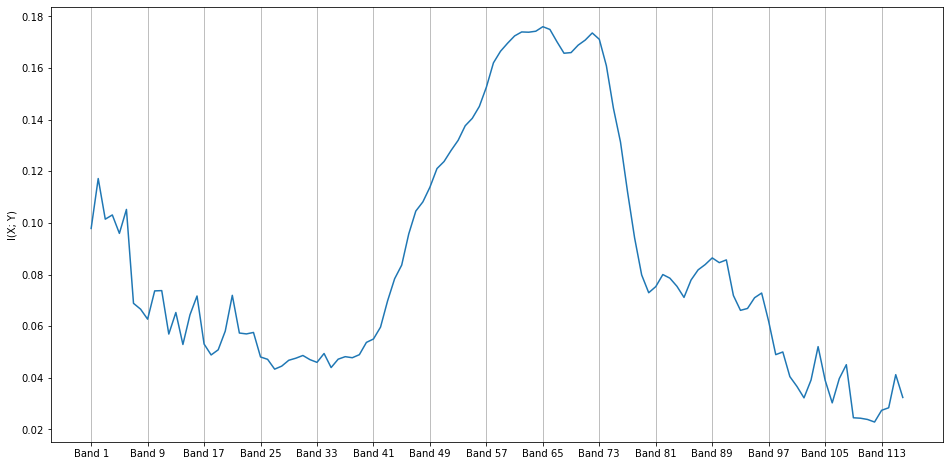

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(selector.mi_)
ax.set_ylabel('I(X; Y)')
ax.set_xticks(np.arange(0, 116, 8))
ax.set_xticklabels(x.columns.values[np.arange(0, 116, 8)])
plt.grid(True, axis='x')
plt.show()

## Features Selected

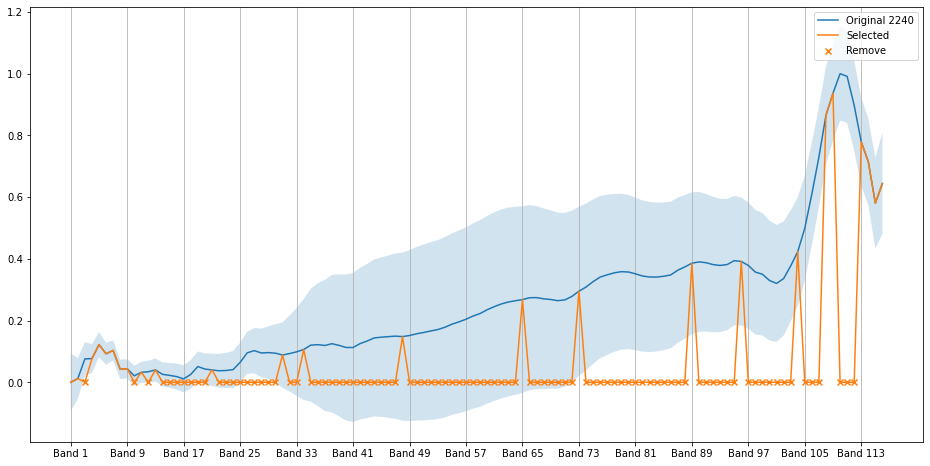

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
sample_idx = 2240
ax.plot(x.iloc[sample_idx], label='Original {}'.format(sample_idx))
ax.fill_between(x.iloc[sample_idx].index, x.iloc[sample_idx] - x.std(), x.iloc[sample_idx] + x.std(), alpha=0.2)
ax.set_xticks(np.arange(0, 116, 8))

data = x.iloc[sample_idx].copy()
data[np.logical_not(selector.mask_)] = 0
ax.plot(data, label='Selected')

features_remove_idx = np.where(selector.mask_ == False)[0]
ax.scatter(features_remove_idx, np.zeros(features_remove_idx.size), marker='x', label='Remove')

plt.grid(True, axis='x')
plt.legend()
plt.show()